# Fitness club attendance database analysis

## Project description 

In front of us is a database of visits to the Kulturist fitness club over the last month. The club has a big problem - customer attrition.
**We need, based on the data provided:**
- predict the probability of churn (at the level of the next month);
- to form typical customer portraits: to identify a few of the most important groups and characterise their main attributes;
- analyse the main attributes most affecting their churn;
- formulate the principal conclusions and develop suggestions for improving the customer experience:

1) identify target client groups;
 
2) to suggest measures to reduce churn;
 
3) determine other features of customer interaction.

**Database** - Customer data for the previous month before the churn check:
- 'gender' - gender;
- 'Near_Location' - living or working in the area where the fitness centre is located;
- 'Partner' - an employee of a partner company of the club (cooperation with companies whose employees can receive discounts on memberships - in this case the fitness centre stores information about the client's employer);
- 'Promo_friends' - the fact of initial enrolment in the 'bring a friend' promotion (used a promo code from an acquaintance when paying for the first subscription);
- 'Phone' - presence of a contact phone number;
- 'Age' - age;
- 'Lifetime' - time since first contact with the fitness centre (in months).

Information based on attendance log, purchases and information on the current status of the client's subscription:
- 'Contract_period' - duration of the current active subscription (month, 6 months, year);
- 'Month_to_end_contract' - period until the end of the current active subscription (in months);
- 'Group_visits' - the fact of attending group classes;
- 'Avg_class_frequency_total' - average frequency of attendance per week for all time since the beginning of the subscription;
- 'Avg_class_frequency_current_month' - average frequency of attendance per week for the previous month;
- 'Avg_additional_charges_total' - total revenue from other services of the fitness centre: café, sports goods, beauty and massage salon.
- 'Churn' - the fact of churn in the current month.

In [55]:
## Import all the libraries which will be used later
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")


# 1. Data Wrangling

In [56]:
# load in data and print out the head 
df=pd.read_csv("/datasets/gym_churn.csv")
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [57]:
# check the rows and columns of this dataset
df.shape

(4000, 14)

We have 4000 records, 14 columns, one of which is the target variable, the others are attributes

In [58]:
# check datatypes to see if there are some wrongly categorized types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

There are no missing values in the table, indicating complete data. All data types are numeric (int or floeat).

In [59]:
#check if there is any duplicate
df.duplicated().sum()

0

There are no duplicates

In [60]:
#replace the register with a snake one
df.columns = df.columns.str.lower()

# 2. Exploratory data analysis

In [61]:
#explore mean and standard deviation over the dataframe
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


As we can see already from the first analysis, the gender of the clients is roughly evenly split, 
the vast majority of them live close to the location.
The average length of a contract is 5 months, but more than 50% of clients have a one-month contract. The average age of a client is 29 years old. And the churn rate is at 26%.

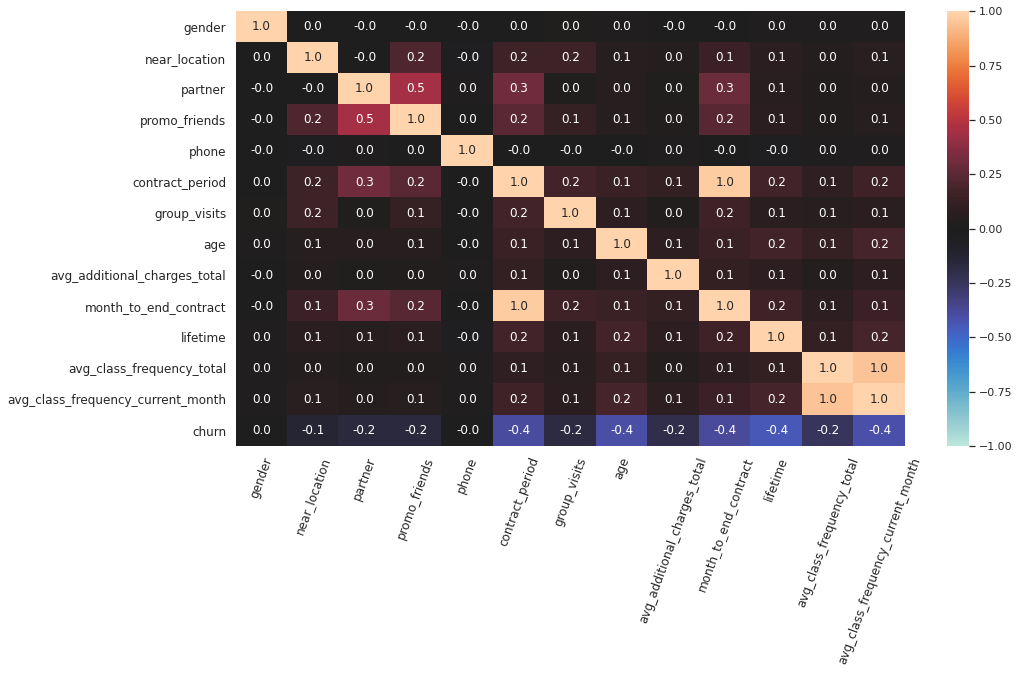

In [62]:
# посмотрим как коррелируют признаки между собой
df_var=df.corr().drop('churn', axis=1)
plt.figure(figsize=(15, 8))
sns.heatmap(df_var, annot=True,vmin=-1, vmax=1, center= 0, fmt = '.1f')
plt.xticks(fontsize=12, rotation=70)
plt.yticks(fontsize=12)
plt.show()

The heatmap shows signs with high correlation, which means that we can then eliminate one of the pairs of highly correlated features. We have the number of months to the end of the contract and the number of months of the contract; average weekly and monthly attendance of additional classes.

In [63]:
#get rid of features with a correlation of 1
df = df.drop('month_to_end_contract',axis=1)
df= df.drop('avg_class_frequency_current_month', axis=1) 


In [64]:
#group the attributes by target variable and look at the average value for each variable
df_gr = df.groupby('churn')[df.columns.drop('churn')].mean().T
df_gr

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
lifetime,4.711807,0.990575


From this table we can already observe some patterns of customer churn: a fewer number live close to the fitness club, and are members of the affiliate programme. Also, half as many clients are brought in by friends, as compared to those who keep coming to the club. The age and extra costs of those who leave are less. The important thing is that clients with shorter contracts of 1 to 2 months on average tend to leave us. 

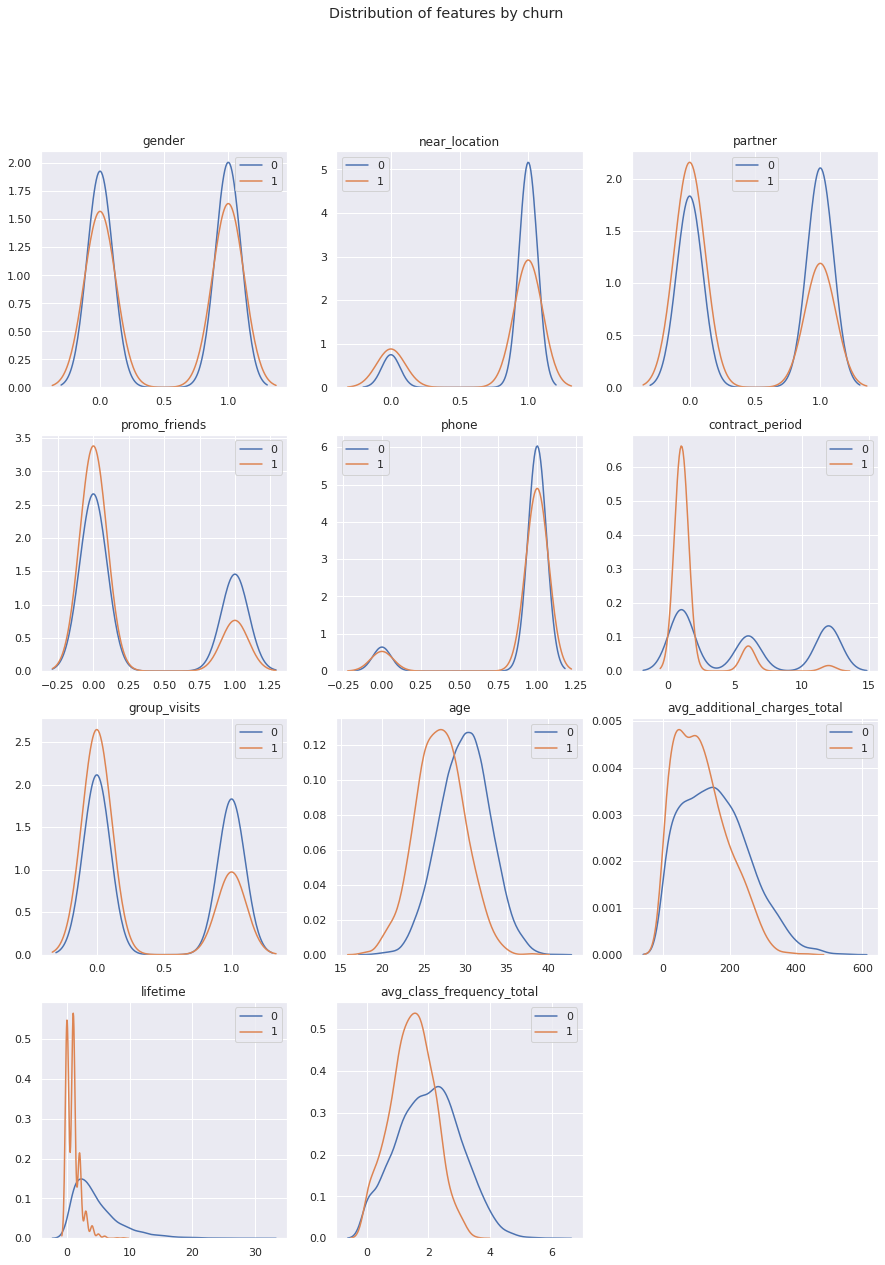

In [65]:
# create bar graphs and feature distributions for those who left (churn) and those who stayed (not in the churn)
features=df.columns.drop('churn')
plt.figure(figsize =(15,20))
for i,j in enumerate(features):
    plt.subplot(4,3,i+1)
    for churn in df['churn'].unique():
        kil=df.query('churn==@churn')
        sns.distplot(kil[j], kde=True, hist=False)
        plt.title(j)
        plt.legend(df['churn'].unique())
        plt.suptitle('Distribution of features by churn')
        plt.ylabel('')
        plt.xlabel('')
        plt.tight_layout


In the graphs above, we can observe customer churn for each feature more closely

# 3. Models to predict client churn

Since our target variable is a binary variable, we will use an algorithm for solving such problems - logistic regression - and compare it with Random Forest.  Based on the metrics accuracy_score, precision_score, recall_score we will see which model works better for our case

In [66]:
# divide our data into features (matrix X) and target variable (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# split the model into a training sample and a validation sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# set and buid the algorithm for the logistic regression
model_lr = LogisticRegression(random_state = 0)
model_lr.fit(X_train,y_train)
pred_lr = model_lr.predict(X_test)
prob_lr = model_lr.predict_proba(X_test)[:,1]
# set and buid the algorithm for Random Forest
model_rf =  RandomForestClassifier(random_state = 0)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
prob_rf = model_rf.predict_proba(X_test)[:, 1]


In [67]:
#calculate the accuracy_score metric from the metrics module
#it will calculate the proportion of correct answers
acc_lr = accuracy_score(y_test, pred_lr)
acc_rf = accuracy_score(y_test, pred_rf)
print('accuracy_score LogisticRegression',round(acc_lr,2))
print('accuracy_score Random Forest', round(acc_rf,2))

accuracy_score LogisticRegression 0.87
accuracy_score Random Forest 0.89


In [68]:
#calculate the precision metric from the metrics module
#it will calculate the proportion of correct answers among the target class only
precision_lr = precision_score(y_test, pred_lr)
precision_rf = precision_score(y_test, pred_rf)
print('precision LogisticRegression', round(precision_lr,2))
print('precision Random Forest', round(precision_rf,2))

precision LogisticRegression 0.73
precision Random Forest 0.78


In [69]:
#Calculate the recall metric from the metrics module
# will see how many real objects of class "1" we were able to detect with the model
recall_rf = recall_score(y_test, pred_rf)
print('recall LogisticRegression', round(recall_lr,2))
print('recall Random Forest', round(recall_rf,2))

recall LogisticRegression 0.76
recall Random Forest 0.77


As you can see from the calculation of the metrics above, Random Forest has performed better than LogisticRegression. For all metrics, the result is Random Forest > LogisticRegression.

# 4. Client clustering

In [70]:
#standardise the data with StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

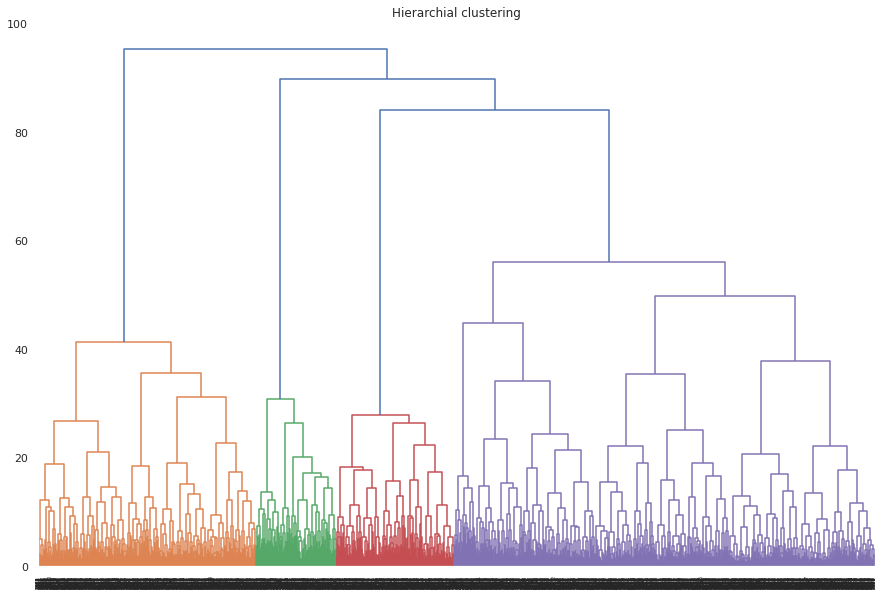

In [71]:
#build a dendogram based on standardised data
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

The dendogram shows the number of main clusters as 5, and this is the number we will use to construct the KMeans

In [72]:
#set model k_means with number of clusters 5 and fix value random_state
cl = KMeans(n_clusters=5, random_state=0)
labels = cl.fit_predict(X_sc)


In [73]:
# save the cluster labels in the field of our dataset
df['cluster'] = labels
# display statistics on the mean values of our features across clusters
clusters = df.groupby(['cluster']).mean()
clusters

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


We identified 5 main clusters and the mean value for the attributes of each of them: 
- Group 0: churn - 39%; do not live close to the location; less than half of the group are employees of the company-partner of the club; average contract period, time from the first contact with the fitness centre is 3 months; the lowest frequency of group classes attended; the lowest age; spend the least on supplementary goods;
- Group 1: churn - 12%; live in the vicinity of the location; almost all the group are employees of the company-partner of the club; 89% were brought in by a "friend" initially; average contract period - almost 8 months; the highest age; spend the most on additional goods; the highest frequency of group classes attended
- Group 2: churn - 38%; live close to the location; 23% of the group are employees of the partner company of the club; average contract period - less than 3 months; low frequency of group exercise; lowest age after group 0; spend little on supplementary goods, but slightly more than group 0;
- Group 3: churn - 20%; live near the location; 25% of the group are employees of a company-partner of the club; but the average period of the contract - 4,5 months; quite high frequency of group classes attended; the highest age after group 1; spend a lot on additional goods, but a little less than group 1;
- group 4: churn - 26%; 86% live close to the location; but average contract period - same as group 3, as most parameters; but clients of this group have not left their phone number

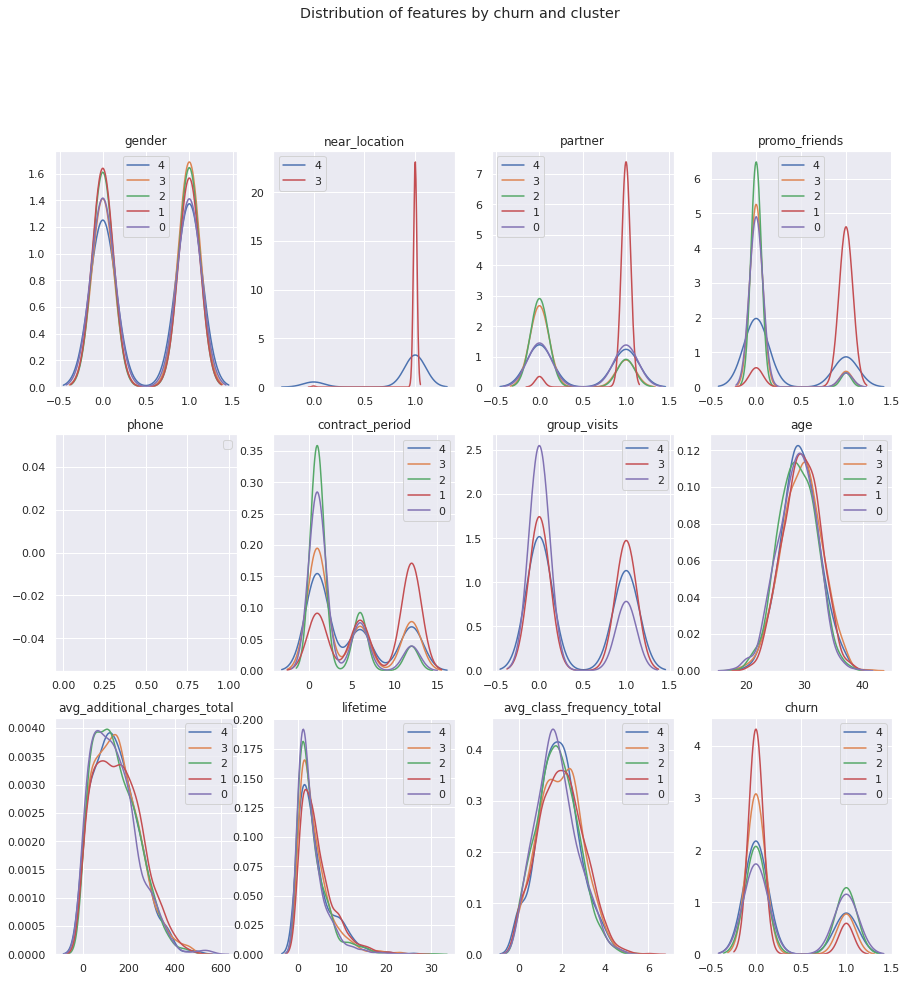

In [74]:
#plot the distributions of features in the clusters
plt.figure(figsize =(15,20))
features=df.columns.drop('cluster')
for i,j in enumerate(features):
    plt.subplot(4,4,i+1)
    for cluster in df['cluster'].unique():
        sns.distplot(df[df['cluster']==cluster][j], kde=True, hist=False)    
    plt.title(j)
    plt.legend(df['cluster'].unique())
    plt.suptitle('Distribution of features by churn and cluster')
    plt.ylabel('')
    plt.xlabel('')
    plt.tight_layout


From the charts, we can see the main attributes that affect churn: 
- the distance to the club from the residence;
- friends' promotional code registration;
- age;
- filled-in phone number in the registration form;
- high attendance at group classes
    

In [75]:
#group the clusters by churn rate
df.groupby('cluster')['churn'].mean().sort_values(ascending=False)

cluster
0    0.399287
2    0.381625
4    0.266839
3    0.200918
1    0.120952
Name: churn, dtype: float64

As we can see, groups 0 and 2 are the most prone to churn, but group 1 is the least likely to churn

# Conclusions 

We did a good job and analysed the customer churn data.
  
  We trained 2 models Logistic Regression and Random Forest, and then we found out that Random Forest is better in all metrics based on the model quality score metrics.
 
 We found that the main attributes that influenced churn were: the distance to the club from the residence; friends' promotional code; age; filled-in phone number in the registration form; high attendance at group classes

 During the study, we identified 5 main clusters-groups of clients:
- Group 0: churn - 39%
- Group 1: churn - 12%
- Group 2: churn - 38%
- Group 3: churn - 20%
- group 4: churn - 26%

Based on the aforementioned, the following **measures to reduce churn** can be proposed:
1. Improve and stimulate the system of encouraging a friend to be a member of the club, such as additional discounts, gifts, or giveaways.
2. Promote the club to older potential customers, who are more loyal to the club as they stay longer and spend more money on related products.
3. To develop a plan to increase the average duration of the contract, as these clients are with us for longer, respectively with other satisfactory parameters - more loyal (family packages, evening, morning passes, convenient time for group/individual training)